<a href="https://colab.research.google.com/github/Hadavand-s-Minions/rsna-cervical-spine/blob/main/assignments/2_Exploratory_DA/Train_Segmentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Necessary Libraries And Modules

These are the libraries we will need for preprocessing image data, splitting the data, training models, computing accuracy and improving model performance

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from PIL import Image
import nibabel as nib
from nibabel import Nifti1Image

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

# from sklearn import decomposition 
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.svm import LinearSVC 
# from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, ParameterGrid

### Mount Files from Google Drive to Read Image and Variable data for analysis

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load the .nii files from segmentations 

We load the .nii files from the segmentations folder below. The .nii files are masked files that contain labels for the vertebrae. As will be seen in the following code cells, each image file is a 3-D containing all the vertebrae and labels 0 - 19. The mask of each slice of the image tells us which vertebrae we are currently observing. For example, we can have a mask [[0,4, 6, 7],[20000, 4999, 799, 500]]. What this means is that the vertebrae we are observing is C4 because it has the second highest count. In all cases, 0 will always have the highest count because it represents areas without images and for the segmentations, there is more area without an image than areas with images.

There are only 87 segmentation images. To train the semantic segmentation model, we will need the corresponding jpeg images so that we can identify the true mask vs the predicted mask. The goal of training a semantic segmentation model is so that the model can easily identify what a C1 - C7 vertebrae looks like since the segmentated images are labeled.

In [ ]:
base_folder: str = "/content/gdrive/MyDrive/Tutorial_Session/hadavands_minions"
segmentations_folder: str = base_folder + "/segmentations/"
training_folder: str = base_folder + "/train_images/"


segmentations_df = pd.DataFrame({
    "segmentations": os.listdir(segmentations_folder)
})

segmentations_df["StudyInstanceUID"] = segmentations_df["segmentations"].str.strip(".nii")

segmentations_df = segmentations_df.set_index("StudyInstanceUID")

training_df = pd.DataFrame({
    "training": os.listdir(training_folder)
})

training_df["StudyInstanceUID"] = training_df["training"]

training_df["training"] = training_folder + training_df["training"]


training_df = training_df.set_index("StudyInstanceUID")

train_df = pd.read_csv(base_folder+"/train.csv")
train_df = train_df.set_index("StudyInstanceUID")

df = pd.concat([segmentations_df, training_df, train_df], axis=1)

df

,segmentations,training,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,,,
1.2.826.0.1.3680043.10633,1.2.826.0.1.3680043.10633.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.10921,1.2.826.0.1.3680043.10921.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.11827,1.2.826.0.1.3680043.11827.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.11988,1.2.826.0.1.3680043.11988.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1.2.826.0.1.3680043.12281,1.2.826.0.1.3680043.12281.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1.2.826.0.1.3680043.23422,NaN,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.30831,NaN,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.501,NaN,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Create new df with only corresponding .nii files

Since we can only train the model with the available .nii and corresponding jpeg files, we create a new dataframe by dropping all rows which do not have .nii files.

In [ ]:
seg_df = df.dropna()
seg_df

,segmentations,training,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,,,
1.2.826.0.1.3680043.10633,1.2.826.0.1.3680043.10633.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.10921,1.2.826.0.1.3680043.10921.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.11827,1.2.826.0.1.3680043.11827.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.11988,1.2.826.0.1.3680043.11988.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1.2.826.0.1.3680043.12281,1.2.826.0.1.3680043.12281.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1.2.826.0.1.3680043.8330,1.2.826.0.1.3680043.8330.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1.2.826.0.1.3680043.8574,1.2.826.0.1.3680043.8574.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.8884,1.2.826.0.1.3680043.8884.nii,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# get the segmentations images
seg_files = seg_df.reset_index()
seg_files = seg_files["segmentations"]
seg_files

0     1.2.826.0.1.3680043.10633.nii
1     1.2.826.0.1.3680043.10921.nii
2     1.2.826.0.1.3680043.11827.nii
3     1.2.826.0.1.3680043.11988.nii
4     1.2.826.0.1.3680043.12281.nii
                  ...              
82     1.2.826.0.1.3680043.8330.nii
83     1.2.826.0.1.3680043.8574.nii
84     1.2.826.0.1.3680043.8884.nii
85     1.2.826.0.1.3680043.8744.nii
86     1.2.826.0.1.3680043.9926.nii
Name: segmentations, Length: 87, dtype: object

In [ ]:
# loop through all the seg images, load them and read them
all_segs = []
for i in range(len(seg_files)):
    image_path: str = f"{segmentations_folder}{seg_files[i]}"
    if os.path.getsize(image_path) > 0:
        image_obj: Nifti1Image = nib.load(image_path)
        all_segs.append(image_obj)

print(f'Type of the image {type(all_segs[1])}.')
print(f'Lenght of list {len(all_segs)}.')

Type of the image <class 'nibabel.nifti1.Nifti1Image'>.
Lenght of list 70.


In [ ]:
# randomly select one of the images
ind = np.random.randint(0, len(all_segs))
all_segs[ind].shape

(512, 512, 672)

In [ ]:
image_data: np.memmap = all_segs[ind].get_fdata()
type(image_data)

numpy.memmap

In [ ]:
height, width, depth = image_data.shape

print(f'The image object has the following dimensions:\nheight={height}\nwidth={width}\ndepth={depth}.')

The image object has the following dimensions:
height=512
width=512
depth=672.


In [ ]:
from typing import Union
def show_3d_image_slice(
    image_data: Union[np.array, np.memmap],
    slice: int
  ) -> None:
  """
  Displays the given slice of a 3D image
  :param image_data: The 3D image data to display
  :param slice: The given slice to show
  """
  plt.imshow(image_data[:, :, slice], cmap="gray")
  plt.axis('off')
  plt.show()

Plotting layer 424
Counts (array([0., 4.]), array([253916,   8228]))


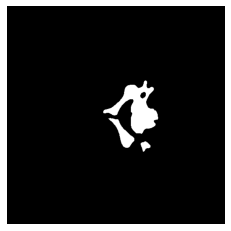

In [ ]:
# visualize one of the layers randomly picked
i = np.random.randint(depth-1)
from collections import Counter
print(f"Plotting layer {i}")
print(f"Counts {np.unique(image_data[:, :, i], return_counts=True)}")

show_3d_image_slice(
    image_data=image_data,
    slice=i
)

In [ ]:
# labels from the masking of segmentation dataset
segmented_labels: dict = {
  "C1": 1,
  "C2": 2,
  "C3": 3,
  "C4": 4,
  "C5": 5,
  "C6": 6,
  "C7": 7,
  "T1": 8,
  "T2": 9,
  "T3": 10,
  "T4": 11,
  "T5": 12,
  "T6": 13,
  "T7": 14,
  "T8": 15,
  "T9": 16,
  "T10": 17,
  "T11": 18,
  "T12": 19,
  "ELSE": 0
}

np.unique(image_data)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

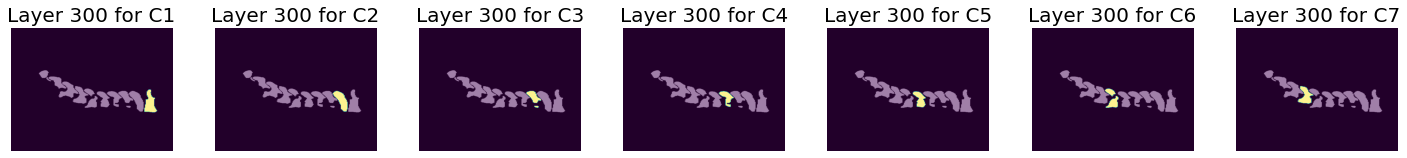

In [ ]:
# have a neck level view by selecting layer we are sure has side view
layer = 300

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20,15))
for i in range(7):
  img_label_str = list(segmented_labels.keys())[i]
  img = image_data[layer, :, :]
  mask = np.where(img == segmented_labels[img_label_str], 255, 0)
  ax[i].imshow(mask)
  ax[i].imshow(image_data[layer, :, :]>0, cmap="gray", alpha=0.5)
  ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=20)
  ax[i].axis('off')
plt.tight_layout()
plt.show()

### Load the jpeg files

In [ ]:
# get the jpeg image files from the df
train_files = seg_df.reset_index()
train_files = train_files["training"]
train_files

0     /content/gdrive/MyDrive/Tutorial_Session/hadav...
1     /content/gdrive/MyDrive/Tutorial_Session/hadav...
2     /content/gdrive/MyDrive/Tutorial_Session/hadav...
3     /content/gdrive/MyDrive/Tutorial_Session/hadav...
4     /content/gdrive/MyDrive/Tutorial_Session/hadav...
                            ...                        
82    /content/gdrive/MyDrive/Tutorial_Session/hadav...
83    /content/gdrive/MyDrive/Tutorial_Session/hadav...
84    /content/gdrive/MyDrive/Tutorial_Session/hadav...
85    /content/gdrive/MyDrive/Tutorial_Session/hadav...
86    /content/gdrive/MyDrive/Tutorial_Session/hadav...
Name: training, Length: 87, dtype: object

In [ ]:
def read_training_study(path: str, ) -> np.array:
  """
  Reads a particular folder of a given study
  and returns a 3D array of the medical images
  stacked on top of each other.

  :param path: The path to the study folder
  """
  study_images: list = []
  images: list = sorted(
      os.listdir(path), 
      key=lambda x: int(x.split('.')[0])  # Sort the image names as numbers
  )

  for image in images:
    study_images.append(
        mpimg.imread(os.path.join(path, image))
    )
  return np.array(study_images).T

In [ ]:
train_study_data = read_training_study(
    path=train_files[0]
)
train_study_data.shape

(512, 512, 429)

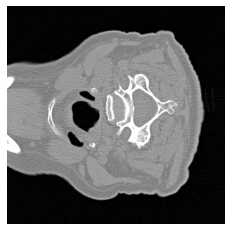

In [ ]:
show_3d_image_slice(
    image_data=train_study_data,
    slice=250
)

In [ ]:
def read_verteb(path):
    '''Function to load the images from the folder
        path: which folder the images are in
    '''
    #read the files from the path 
    files = os.scandir(path)
    files = [i.name for i in files]
    return files

# read the same file as the one that was read in the segementations
files = read_verteb(f"{training_folder}{train_files[ind]}")
print(f"Type of file containing images {type(files)}")
print(f"Number of image files in folder is {len(files)}")
print(f"name of current folder {training_folder}{train_files[ind]}")

Type of file containing images <class 'list'>
Number of image files in folder is 238
name of current folder /content/gdrive/MyDrive/Tutorial_Session/hadavands_minions/train_images/1.2.826.0.1.3680043.30640


In [ ]:
# def img_to_arr(imgs, path):
#     #list to store images
#     # flatt[[ened = []
#     final =[]
#     # for each image combine the name with path 
#     for img in imgs:
#         # open it as a read file in binary mode
#         with open(path+img, 'r+b') as f:
#             # open it as an image
#             with Image.open(f) as image:
#                 # resize the image to be more manageable
#                 #cover = resizeimage.resize_cover(image, [512, 512])
#                 # cover = image.resize((512,512))
#                 # flattened.append((np.array(cover).flatten(), 0))
#                 final.append(image.resize((512, 512)))
                
                
#     # Flatten it once more
#     final = np.asarray(final)
    
#     return final
# vertebs = img_to_arr(files, f"{training_folder}{train_files[ind]}/")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# plt.imshow(Image.fromarray(vertebs[files.index("220.jpg")]), cmap="gray")
# plt.axis('off')
# plt.show()

In [ ]:
from collections import Counter
print(f"Plotting layer {i}")
print(f"Counts {np.unique(image_data[:, :, i], return_counts=True)}")

plt.imshow(np.rot90(image_data[:, :, 115]), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
print(f'Type of the image {type(files[1])}.')
print(f'Lenght of list {len(files)}.')

Type of the image <class 'str'>.
Lenght of list 238.


## Model Building and Training

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def resize(input_image):
    '''Function to resize images and mask to 128*128'''
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    # input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
    return input_image

# def resize(input_image, input_mask):
#     '''Function to resize images and mask to 128*128'''
#     # input_image = tf.image.resize(input_image, (128, 128), method="nearest")
#     input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
#     return input_image, input_mask

In [ ]:
def normalize(input_mask):
    # input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
  
    return input_mask
# def normalize(input_image, input_mask):
#     # input_image = tf.cast(input_image, tf.float32) / 255.0
#     input_mask -= 1
  
#     return input_image, input_mask

In [ ]:
def load_image_train(input_image):
    # input_image = datapoint["segmentation"]
    # input_mask = datapoint["training"]
    input_image = resize(input_image)
    input_image = normalize(input_image)
    return input_image
# def load_image_train(input_image, input_mask):
#     # input_image = datapoint["segmentation"]
#     # input_mask = datapoint["training"]
#     input_image, input_mask = resize(input_image, input_mask)
#     input_image, input_mask = augment(input_image, input_mask)
#     input_image, input_mask = normalize(input_image, input_mask)
#     return input_image, input_mask

In [ ]:
layer = 300
# train = load_image_train(image_data[:, :, :], vertebs[files.index("251.jpg"),0])
# train = load_image_train(vertebs[files.index("251.jpg"),0], vertebs[files.index("251.jpg"),0])
train = load_image_train(image_data[:, :, :])
train

<tf.Tensor: shape=(128, 128, 399), dtype=float64, numpy=
array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       ...,

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -

In [ ]:
len(train)

128

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [ ]:
def display_imgs(display_list):
    plt.figure(figsize=(10, 18))

#   title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        # plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis("off")
    plt.show()

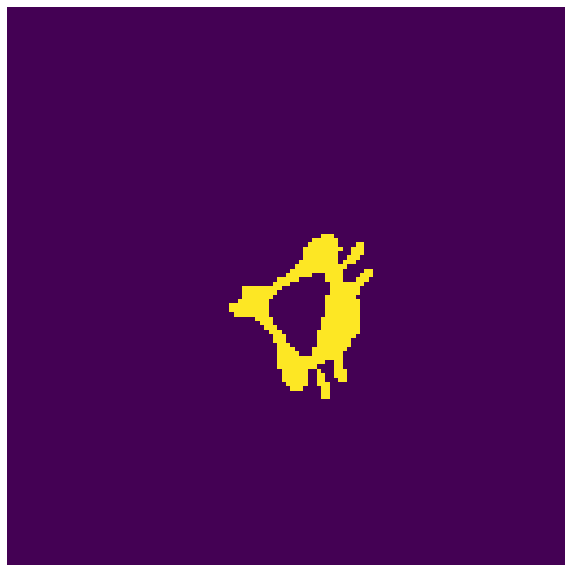

In [ ]:

sample_batch = next(iter(train))
# random_index = np.random.choice(sample_batch[0].shape[0])
sample_image = sample_batch[0][random_index]
display_imgs([train[: , :, random_index]])


In [ ]:
sample_mask

<tf.Tensor: shape=(334,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
# set the theme for EDA
sns.set_theme(palette='muted')

## U-Net Building Blocks

In [ ]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [ ]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# compile and train unet
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy")